# Library

In [203]:
# 라이브러리
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore') 

pd.options.display.float_format = '{:.5f}'.format # 지수표현을 소숫점 표현으로

# Data Load

In [204]:
data1 = pd.read_csv('../dataset/data1.csv') # 지하철 혼잡도 정보 2020년 7월 8일 데이터??

# data2 = pd.read_csv('../dataset/data2.csv') # 역사 대기 정보
data2 = pd.read_csv('../dataset/new_data2.csv')

data3 = pd.read_csv('../dataset/data3.csv') # 자치구별 지하철역 정보

# Data Preprocessing

- 호선 변수에서 '1호선'을 '1'로 변경

In [205]:
def trim1(A):
    if A[-2:] == '호선':
        A = A[0:-2]
    return A

In [206]:
data1['호선'] = data1['호선'].apply(trim1)

- 호선은 범주형 데이터이기 때문에 수치로 들어가면 모델이 호선의 번호가 작으면 값이 커지고, 호선의 번호가 크면 값이 작아진다는 식으로 학습할 수 있음.
    
    
    따라서 원핫 인코딩을 사용하여 범주화해주었습니다.

In [207]:
dummy = pd.get_dummies(data1['호선'], prefix='호선')

In [208]:
dummy['역번호'] = data1['역번호'] # 더미에 '역번호' 변수추가. merge를 위함

In [209]:
dummy = dummy.drop_duplicates() # 중복 행 제거

In [210]:
dummy

,호선_1,호선_2,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,역번호
0,1,0,0,0,0,0,0,0,0,0,150
2,1,0,0,0,0,0,0,0,0,0,151
4,1,0,0,0,0,0,0,0,0,0,152
6,1,0,0,0,0,0,0,0,0,0,153
8,1,0,0,0,0,0,0,0,0,0,154
...,...,...,...,...,...,...,...,...,...,...,...
546,0,0,0,0,0,0,0,1,0,0,2823
548,0,0,0,0,0,0,0,1,0,0,2824
550,0,0,0,0,0,0,0,1,0,0,2825
552,0,0,0,0,0,0,0,1,0,0,2826


In [211]:
data1.head(1)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00,24:30:00
0,평일,1,150,서울역,상선,8.20000,12.90000,21.50000,28.40000,46.70000,...,15.10000,15.90000,17.10000,16.00000,19.00000,15.20000,10.50000,7.80000,6.00000,0.90000


- data1에서, 5:30 ~ 24:30의 혼잡도를 평균낸 변수를 사용하도록 하겠습니다.

In [129]:
avg = pd.Series(data1.groupby('역번호').mean().transpose().mean()) # 역 번호 별 하루동안의 평균 혼잡도
avg = pd.DataFrame(avg).reset_index()
avg.columns = '역번호', '혼잡도'

In [130]:
pd.merge(dummy, avg, how = 'right')

,호선_1,호선_2,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,역번호,혼잡도
0,1,0,0,0,0,0,0,0,0,0,150,28.72479
1,1,0,0,0,0,0,0,0,0,0,151,27.41453
2,1,0,0,0,0,0,0,0,0,0,152,26.81923
3,1,0,0,0,0,0,0,0,0,0,153,27.07350
4,1,0,0,0,0,0,0,0,0,0,154,27.15427
...,...,...,...,...,...,...,...,...,...,...,...,...
273,0,0,0,0,0,0,0,1,0,0,2823,13.45598
274,0,0,0,0,0,0,0,1,0,0,2824,10.12179
275,0,0,0,0,0,0,0,1,0,0,2825,7.81111
276,0,0,0,0,0,0,0,1,0,0,2826,7.02735


- 역 번호별로 몇호선인지 범주화하였고, 평균혼잡도 변수를 추가하여 넣어주었습니다.

In [131]:
pd.DataFrame(pd.merge(dummy, avg, how = 'right').drop('역번호', axis=1).corr()['혼잡도'])

,혼잡도
호선_1,-0.02518
호선_2,0.40741
호선_3,0.01929
호선_4,0.10818
호선_5,-0.24044
호선_6,-0.26386
호선_7,0.11844
호선_8,-0.06338
호선_성수지선,-0.18740
호선_신정지선,-0.04270


- 혼잡도와 2호선 변수와의 상관계수가 0.4, 5호선과 -0.24, 6호선과 -0.26의 상관계수를 가짐을 볼 수 있습니다.

In [132]:
new_data1 = pd.merge(data1, dummy)

- 위에서 만든 dummy 데이터프레임을 data1과 병합해줍니다.

In [133]:
data1.drop('역번호', axis=1).groupby('조사일자').mean()

,5:30,6:00,6:30,7:00,7:30,8:00,8:30,9:00,9:30,10:00,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00,24:30:00
조사일자,,,,,,,,,,,,,,,,,,,,,
일요일,10.75037,9.99655,8.85191,8.63829,10.72868,14.91579,16.08040,20.68439,22.56007,22.96806,...,19.31180,19.69746,20.18167,18.75862,19.93303,17.60944,15.05662,10.37083,NaN,NaN
토요일,18.77537,16.53593,13.27822,13.11942,16.40581,23.73811,24.58566,28.23140,29.11397,28.66770,...,24.56606,24.88348,26.37967,26.64537,29.17260,28.80962,27.89038,22.28862,NaN,NaN
평일,20.60845,19.50594,21.23112,29.36691,41.23525,56.50144,45.83004,37.76637,32.57554,27.16637,...,28.14047,27.68615,29.61529,30.18921,33.24263,29.52572,24.24946,17.94982,10.68669,7.09838


- 조사일자의 경우 범주형이지만, 혼잡도가 평일 > 토요일 > 일요일의 경향성이 있기에 평일은 2, 토요일은 1, 일요일은 0의 숫자를 부여하였습니다.

In [134]:
new_data1.loc[new_data1['조사일자'] == '평일', '조사일자'] = 2
new_data1.loc[new_data1['조사일자'] == '토요일', '조사일자'] = 1
new_data1.loc[new_data1['조사일자'] == '일요일', '조사일자'] = 0

new_data1['조사일자'] = new_data1['조사일자'].astype(int) # 오브젝트를 int형으로

In [135]:
avg = new_data1[['5:30', '6:00', '6:30', '7:00', '7:30','8:00', '8:30', '9:00', '9:30', '10:00', '10:30', '11:00', '11:30',
       '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30',
       '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30',
       '20:00', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00', '23:30',
       '24:00:00', '24:30:00']].transpose().mean()

In [136]:
avg

0      29.74615
1      34.38974
2      33.87297
3      36.68108
4      20.48919
         ...   
1663    0.00000
1664    6.28649
1665    0.00000
1666    5.85946
1667    0.00000
Length: 1668, dtype: float64

In [137]:
new_data1['평균혼잡도'] = avg

- data1에 '평균혼잡도' 변수를 추가합니다.

- 여기서 평균혼잡도가 0인 데이터와 결측치는 삭제해주도록 하겠습니다.

In [138]:
new_data1 = new_data1.drop(new_data1[new_data1['평균혼잡도'] == 0].index, axis = 0)
new_data1 = new_data1.drop(new_data1[new_data1['평균혼잡도'].isna()].index, axis = 0)

In [139]:
new_data1.head(3)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_2,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도
0,2,1,150,서울역,상선,8.20000,12.90000,21.50000,28.40000,46.70000,...,0,0,0,0,0,0,0,0,0,29.74615
1,2,1,150,서울역,하선,11.80000,13.50000,12.20000,17.80000,26.40000,...,0,0,0,0,0,0,0,0,0,34.38974
2,1,1,150,서울역,상선,8.10000,13.20000,15.60000,14.40000,15.90000,...,0,0,0,0,0,0,0,0,0,33.87297


In [140]:
new_data1.corr()['조사일자']['평균혼잡도']

0.356515395826273

- 조사일자와 평균혼잡도 사이에 0.3의 상관계수가 있습니다.

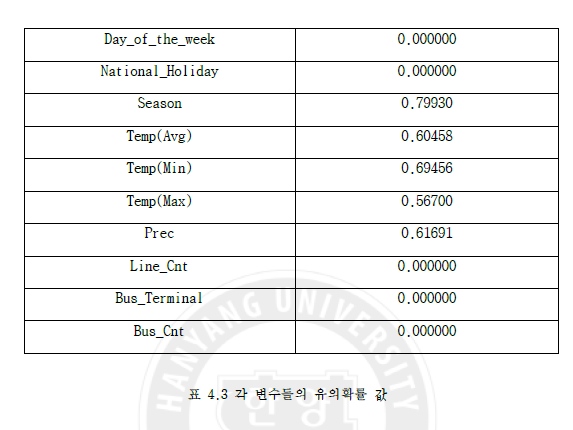

논문에 따르면 역 근처에 버스터미널이 있을 때 승하차 인원이 많다는것 가정이 유의하다고 합니다. 이에따라 버스터미널 변수도 추가해주었습니다.

In [141]:
new_data1['버스터미널'] = 0

new_data1.loc[new_data1['역명'] == '고속터미널', '버스터미널'] = 1 # 서울고속버스터미널
new_data1.loc[new_data1['역명'] == '남부터미널', '버스터미널'] = 1 # 센트럴시티 터미널
new_data1.loc[new_data1['역명'] == '강변', '버스터미널'] = 1 # 동서울 종합터미널
new_data1.loc[new_data1['역명'] == '상봉', '버스터미널'] = 1 # 상봉 터미널

- '구분'변수

In [142]:
new_data1[new_data1['구분'] == '상선'].head(3)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도,버스터미널
0,2,1,150,서울역,상선,8.20000,12.90000,21.50000,28.40000,46.70000,...,0,0,0,0,0,0,0,0,29.74615,0
2,1,1,150,서울역,상선,8.10000,13.20000,15.60000,14.40000,15.90000,...,0,0,0,0,0,0,0,0,33.87297,0
4,0,1,150,서울역,상선,3.40000,7.40000,8.50000,7.90000,10.30000,...,0,0,0,0,0,0,0,0,20.48919,0


In [143]:
new_data1[new_data1['구분'] == '하선'].head(3)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도,버스터미널
1,2,1,150,서울역,하선,11.80000,13.50000,12.20000,17.80000,26.40000,...,0,0,0,0,0,0,0,0,34.38974,0
3,1,1,150,서울역,하선,18.30000,13.70000,9.70000,13.80000,9.70000,...,0,0,0,0,0,0,0,0,36.68108,0
5,0,1,150,서울역,하선,7.90000,7.20000,5.50000,7.10000,5.40000,...,0,0,0,0,0,0,0,0,22.24054,0


- 하선 > 상선

In [144]:
new_data1[new_data1['구분'] == '내선'].head(3)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도,버스터미널
60,2,2,201,시청,내선,19.70000,19.70000,25.50000,36.00000,52.60000,...,0,0,0,0,0,0,0,0,38.96154,0
62,1,2,201,시청,내선,23.70000,15.50000,14.10000,13.40000,16.00000,...,0,0,0,0,0,0,0,0,37.23514,0
64,0,2,201,시청,내선,18.10000,11.70000,10.30000,11.20000,16.60000,...,0,0,0,0,0,0,0,0,30.56757,0


In [145]:
new_data1[new_data1['구분'] == '외선'].head(3)

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도,버스터미널
61,2,2,201,시청,외선,12.50000,20.40000,11.80000,18.10000,33.20000,...,0,0,0,0,0,0,0,0,40.05641,0
63,1,2,201,시청,외선,15.10000,17.30000,8.40000,7.60000,10.90000,...,0,0,0,0,0,0,0,0,41.32973,0
65,0,2,201,시청,외선,4.90000,9.20000,5.40000,5.40000,8.50000,...,0,0,0,0,0,0,0,0,30.78378,0


- 외선 > 내선

하선 > 상선, 외선 > 내선이므로 하선과 외선에는 1, 상선과 내선에는 0을 부여하도록 하겠습니다.

In [146]:
new_data1.loc[new_data1['구분']=='하선', '구분'] = 1
new_data1.loc[new_data1['구분']=='외선', '구분'] = 1

new_data1.loc[new_data1['구분']=='상선', '구분'] = 0
new_data1.loc[new_data1['구분']=='내선', '구분'] = 0

new_data1['구분'] = new_data1['구분'].astype(int) # 오브젝트를 int형으로

In [162]:
new_data1

,조사일자,호선,역번호,역명,구분,5:30,6:00,6:30,7:00,7:30,...,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,평균혼잡도,버스터미널
0,2,1,150,서울역,0,8.20000,12.90000,21.50000,28.40000,46.70000,...,0,0,0,0,0,0,0,0,29.74615,0
1,2,1,150,서울역,1,11.80000,13.50000,12.20000,17.80000,26.40000,...,0,0,0,0,0,0,0,0,34.38974,0
2,1,1,150,서울역,0,8.10000,13.20000,15.60000,14.40000,15.90000,...,0,0,0,0,0,0,0,0,33.87297,0
3,1,1,150,서울역,1,18.30000,13.70000,9.70000,13.80000,9.70000,...,0,0,0,0,0,0,0,0,36.68108,0
4,0,1,150,서울역,0,3.40000,7.40000,8.50000,7.90000,10.30000,...,0,0,0,0,0,0,0,0,20.48919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,0,8,2826,수진,0,2.40000,2.20000,2.20000,2.20000,2.50000,...,0,0,0,0,0,1,0,0,6.59189,0
1661,0,8,2826,수진,1,11.00000,3.70000,3.20000,2.60000,4.10000,...,0,0,0,0,0,1,0,0,5.92703,0
1662,2,8,2827,모란,0,2.50000,2.60000,2.50000,2.10000,3.00000,...,0,0,0,0,0,1,0,0,7.81026,0
1664,1,8,2827,모란,0,2.40000,2.70000,2.20000,2.10000,2.30000,...,0,0,0,0,0,1,0,0,6.28649,0


# Modeling

- 독립변수를 ['조사일자', '구분', '호선', '버스터미널'], 종속변수를 ['평균혼잡도']로 하여 모델을 만들어 보겠습니다.

In [147]:
from sklearn.model_selection import train_test_split

In [185]:
x_train, x_test, y_train, y_test = train_test_split(new_data1[[
    '조사일자', '구분', '호선_1', '호선_2', '호선_3', '호선_4', '호선_5',
    '호선_6', '호선_7', '호선_8', '호선_성수지선', '호선_신정지선','버스터미널']], 
    new_data1['평균혼잡도'], test_size = 0.2, shuffle = True, random_state = 19)

In [199]:
x_train['평균혼잡도'] = y_train

In [201]:
x_train

,조사일자,구분,호선_1,호선_2,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,버스터미널,평균혼잡도
465,1,1,0,0,1,0,0,0,0,0,0,0,0,48.13514
501,1,1,0,0,1,0,0,0,0,0,0,0,1,33.38919
239,0,1,0,1,0,0,0,0,0,0,0,0,0,33.13243
420,2,0,0,0,1,0,0,0,0,0,0,0,0,45.75385
240,2,0,0,1,0,0,0,0,0,0,0,0,0,45.15897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,0,1,0,0,0,0,0,1,0,0,0,0,0,19.22973
951,1,1,0,0,0,0,1,0,0,0,0,0,0,28.84324
1420,0,0,0,0,0,0,0,0,1,0,0,0,0,30.53784
772,0,0,0,0,0,0,1,0,0,0,0,0,0,12.82703


In [202]:
x_train.corr()['평균혼잡도']

조사일자       0.34359
구분         0.00534
호선_1      -0.03155
호선_2       0.35736
호선_3       0.04023
호선_4       0.08911
호선_5      -0.24360
호선_6      -0.22569
호선_7       0.09480
호선_8      -0.04402
호선_성수지선   -0.16127
호선_신정지선   -0.01572
버스터미널      0.10049
평균혼잡도      1.00000
Name: 평균혼잡도, dtype: float64

In [189]:
x_train.head(3)

,조사일자,구분,호선_1,호선_2,호선_3,호선_4,호선_5,호선_6,호선_7,호선_8,호선_성수지선,호선_신정지선,버스터미널
465,1,1,0,0,1,0,0,0,0,0,0,0,0
501,1,1,0,0,1,0,0,0,0,0,0,0,1
239,0,1,0,1,0,0,0,0,0,0,0,0,0


In [190]:
y_train.head(3)

465   48.13514
501   33.38919
239   33.13243
Name: 평균혼잡도, dtype: float64

In [191]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [192]:
from sklearn.linear_model import LinearRegression

In [193]:
linear = LinearRegression()
linear.fit(x_train, y_train)
predl = linear.predict(x_test)
mean_squared_error(y_test, predl)

95.64909382752951

- 선형회귀로 예측한 결과입니다.

In [194]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123,max_depth=6) # 랜덤포레스트 모델
rf.fit(x_train, y_train) # 모형 적합
predrf = rf.predict(x_test) # 예측

In [195]:
mean_squared_error(y_test, predrf)

94.80235778926885

- 랜덤포레스트로 예측한 결과입니다.

선형회귀보다는 랜덤포레스트의 결과가 더 좋음을 볼 수 있습니다.

In [196]:
import seaborn as sns

predicted = rf.predict(x_test)
expected = np.array(y_test)


df = pd.DataFrame([expected, predicted])
# plt.figure(figsize=(8,4))
# plt.scatter(expected,predicted)
# snsplot = sns.lmplot(x='expected', y='predicted', data=df, ci=None)
#plt.plot([30,400],[30,400],'--r')
# plt.tight_layout

In [197]:
df = df.transpose()
df.columns = ['expected', 'predicted']
df

,expected,predicted
0,36.09487,34.24655
1,38.41795,42.88314
2,7.66757,20.52051
3,32.23514,20.52051
4,17.32308,23.33452
...,...,...
319,13.10000,21.25878
320,22.02973,17.56288
321,33.42564,42.88314
322,55.70000,42.88314


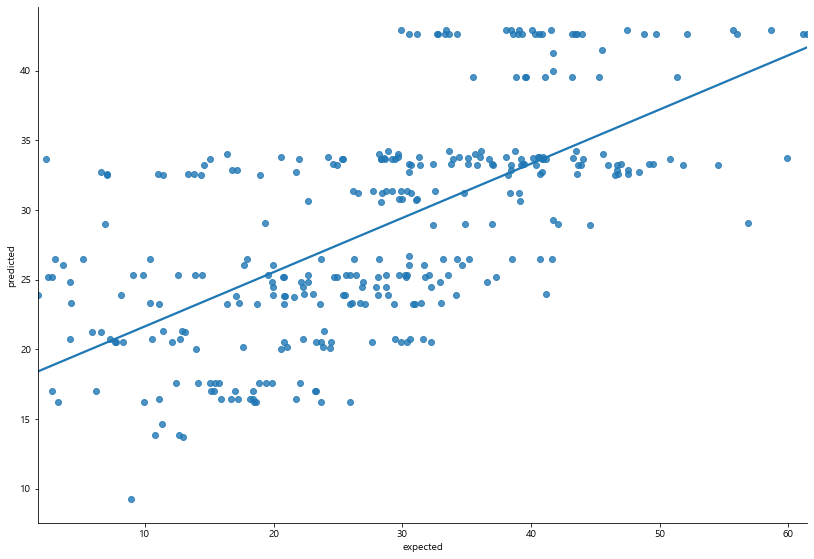

In [198]:
snsplot = sns.lmplot(x='expected',y='predicted',data=df,ci=None)
snsplot.fig.set_size_inches(12,8)
plt.xlabel('expected')
plt.ylabel('predicted')
plt.show()

- 기댓값과 예측값은 다음과 같은 분포를 보입니다.

- 만든 모델을 사용하면, 
1. 평일인지 주말인지
2. 상선인지 하선인지 외선인지 내선인지
3. 몇호선인지
4. 버스터미널이 있는지

    이 값들만 대입을 해주면, 혼잡도를 어느정도 예상할 수 있습니다.